# **Introduction**

This is an initial Explanatory Data Analysis for the [Mercari Price Suggestion Challenge](https://www.kaggle.com/c/mercari-price-suggestion-challenge#description) with matplotlib. [bokeh](https://bokeh.pydata.org/en/latest/) and [Plot.ly](https://plot.ly/feed/) - a visualization tool that creates beautiful interactive plots and dashboards.  The competition is hosted by Mercari, the biggest Japanese community-powered shopping app with the main objective to predict an accurate price that Mercari should suggest to its sellers, given the item's information. 

***Update***: the NLP analysis and found an amazing tutorial by Ahmed BESBES. The framework below is  based on his [source code](https://ahmedbesbes.com/how-to-mine-newsfeed-data-and-extract-interactive-insights-in-python.html).  It provides guidance on pre-processing documents and  machine learning techniques (K-means and LDA) to clustering topics.  So that this kernel will be divided into 2 parts: 

1. Explanatory Data Analysis 
2. Text Processing  
    2.1. Tokenizing and  tf-idf algorithm  
    2.2. K-means Clustering  
    2.3. Latent Dirichlet Allocation (LDA)  / Topic Modelling

In [1]:
import nltk
import string
import re
import numpy as np
import pandas as pd
import pickle
#import lda

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")

from nltk.stem.porter import *
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction import stop_words

from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
%matplotlib inline

import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, show, output_notebook
#from bokeh.transform import factor_cmap

import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger("lda").setLevel(logging.WARNING)

# **Exploratory Data Analysis**
On the first look at the data, besides the unique identifier (item_id), there are 7 variables in this model. This notebook will sequentially go through each of them with a brief statistical summary. 

1. **Numerical/Continuous Features**
    1. price: the item's final bidding price. This will be our reponse / independent variable that we need to predict in the test set
    2. shipping cost     
 
1. **Categorical Features**: 
    1. shipping cost: A binary indicator, 1 if shipping fee is paid by seller and 0 if it's paid by buyer
    2. item_condition_id: The condition of the items provided by the seller
    1. name: The item's name
    2. brand_name: The item's producer brand name
    2. category_name: The item's single or multiple categories that are separated by "\" 
    3. item_description: A short description on the item that may include removed words, flagged by [rm]

In [2]:
%%time
train = pd.read_csv('data/train.tsv', sep='\t')
test = pd.read_csv('data/test.tsv', sep='\t')
print(train.shape)
print(test.shape)

(1482535, 8)
(693359, 7)
CPU times: user 5.71 s, sys: 302 ms, total: 6.01 s
Wall time: 6.26 s


In [3]:
train.dtypes

train_id               int64
name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
dtype: object

In [4]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


### Target Variable: Price
The next standard check is with our response or target variables, which in this case is the price we are suggesting to the Mercari's marketplace sellers. The median price of all the items in the training is about \$267 but given the existence of some extreme values of over \$100 and the maximum at \$2,009, the distribution of the variables is heavily skewed to the left. So let's make log-transformation on the price (we added +1 to the value before the transformation to avoid zero and negative values).

In [5]:
train['price'].describe()

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

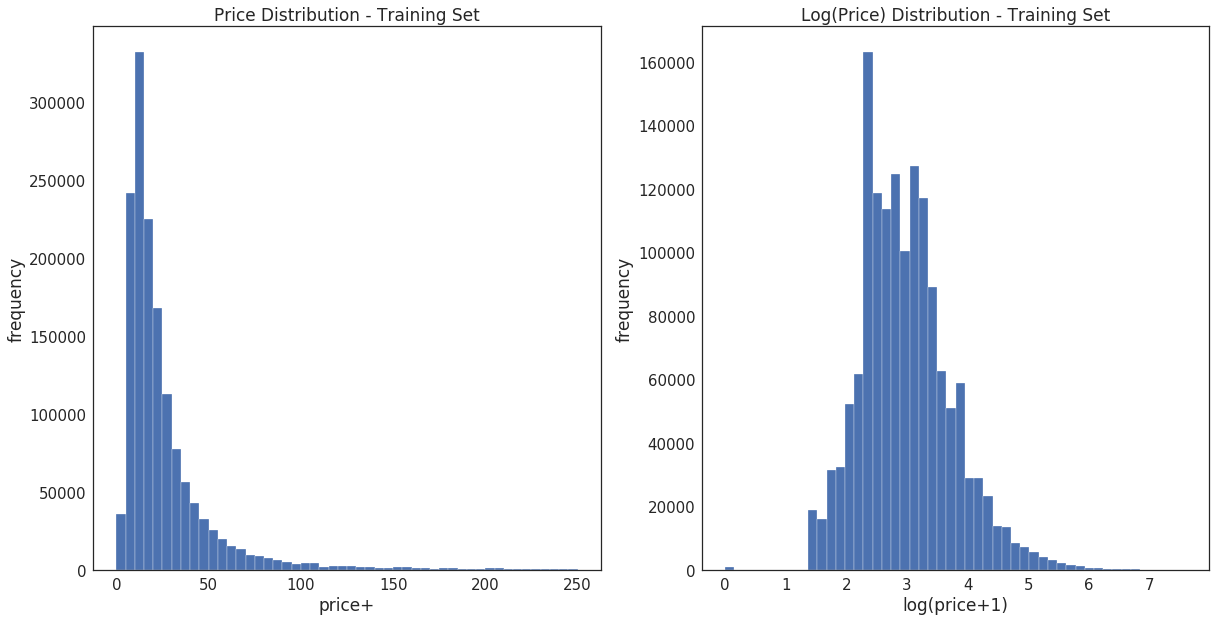

In [6]:
plt.subplot(1, 2, 1)
(train['price']).plot.hist(bins=50, figsize=(20,10), edgecolor='white',range=[0,250])
plt.xlabel('price+', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.tick_params(labelsize=15)
plt.title('Price Distribution - Training Set', fontsize=17)

plt.subplot(1, 2, 2)
np.log(train['price']+1).plot.hist(bins=50, figsize=(20,10), edgecolor='white')
plt.xlabel('log(price+1)', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.tick_params(labelsize=15)
plt.title('Log(Price) Distribution - Training Set', fontsize=17)
plt.show()

## **Shipping**

The shipping cost burden is decently splitted between sellers and buyers with more than half of the items' shipping fees are paid by the sellers (55%). In addition, the average price paid by users who have to pay for shipping fees is lower than those that don't require additional shipping cost. This matches with our perception that the sellers need a lower price to compensate for the additional shipping.

In [7]:
train['shipping'].value_counts()

0    819435
1    663100
Name: shipping, dtype: int64

In [8]:
train.shipping.value_counts()/len(train)

0    0.552726
1    0.447274
Name: shipping, dtype: float64

In [9]:
prc_shipBySeller = train.loc[train.shipping==1, 'price']
prc_shipByBuyer = train.loc[train.shipping==0, 'price']

In [10]:
prc_shipBySeller.mean(), prc_shipByBuyer.mean()

(22.56772583320766, 30.111777627267568)

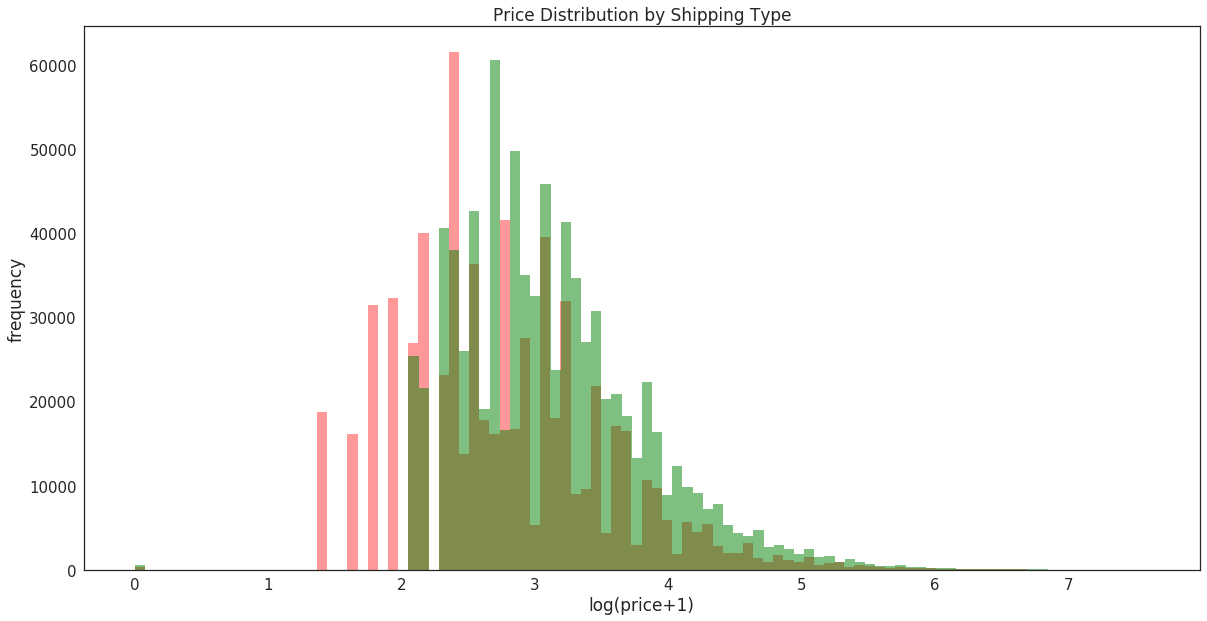

In [11]:
fig, ax = plt.subplots(figsize=(20,10))
ax.hist(np.log(prc_shipBySeller+1), color='red', alpha=.4, bins=100,
       label='Price when Seller pays Shipping')
ax.hist(np.log(prc_shipByBuyer+1), color='green', alpha=0.5, bins=100,
       label='Price when Buyer pays Shipping')
ax.set(title='Histogram Comparison', ylabel='% of Dataset in Bin')
plt.xlabel('log(price+1)', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.title('Price Distribution by Shipping Type', fontsize=17)
plt.tick_params(labelsize=15)
plt.show()

## **Item Category**

There are about **1,287** unique categories but among each of them, we will always see a main/general category firstly, followed by two more particular subcategories (e.g. Beauty/Makeup/Face or Lips). In adidition, there are about 6,327 items that do not have a category labels. Let's split the categories into three different columns. We will see later that this information is actually quite important from the seller's point of view and how we handle the missing information in the `brand_name` column will impact the model's prediction. 

In [12]:
print("There are %d unique values in the category column." % train['category_name'].nunique())

There are 1287 unique values in the category column.


In [13]:
# TOP 5 RAW CATEGORIES
train['category_name'].value_counts()[:5]

Women/Athletic Apparel/Pants, Tights, Leggings    60177
Women/Tops & Blouses/T-Shirts                     46380
Beauty/Makeup/Face                                34335
Beauty/Makeup/Lips                                29910
Electronics/Video Games & Consoles/Games          26557
Name: category_name, dtype: int64

In [14]:
# missing categories
print("There are %d items that do not have a label." % train['category_name'].isnull().sum())

There are 6327 items that do not have a label.


In [15]:
train['category_name'].apply(lambda x: str(x).count('/')).value_counts()

2    1471819
0       6327
4       3059
3       1330
Name: category_name, dtype: int64

In [16]:
# reference: BuryBuryZymon at https://www.kaggle.com/maheshdadhich/i-will-sell-everything-for-free-0-55
def split_cat(text):
    try: return text.split("/")
    except: return ("No Label", "No Label", "No Label")

In [17]:
train['category_name'].apply(lambda x: split_cat(x)).apply(len).value_counts()

3    1478146
5       3059
4       1330
Name: category_name, dtype: int64

In [18]:
zip([1,2,3], [2,3,4], [3,4,5,6], [7,8],[9,10])

[(1, 2, 3, 7, 9), (2, 3, 4, 8, 10)]

In [19]:
train['category_name'][train['category_name'].apply(lambda x: str(x).count('/'))==0].shape
train['category_name'][train['category_name'].apply(lambda x: str(x).count('/'))==0].tail()

1481249    NaN
1481750    NaN
1482252    NaN
1482443    NaN
1482473    NaN
Name: category_name, dtype: object

In [20]:
train['category_name'].dropna().apply(lambda x: split_cat(x)).apply(len).value_counts()

3    1471819
5       3059
4       1330
Name: category_name, dtype: int64

https://stackoverflow.com/questions/2921847/what-does-the-star-operator-mean

https://stackoverflow.com/questions/36901/what-does-double-star-asterisk-and-star-asterisk-do-for-parameters

In [21]:
len(zip(*train['category_name'].apply(lambda x: split_cat(x))))

3

In [22]:
type(zip(*train['category_name'].apply(lambda x: split_cat(x)))[0])

tuple

In [23]:
train['general_cat'], train['subcat_1'], train['subcat_2'] = \
zip(*train['category_name'].apply(lambda x: split_cat(x)))
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


In [24]:
print("There are %d unique first sub-categories." % train['subcat_1'].nunique())

There are 114 unique first sub-categories.


In [25]:
print("There are %d unique second sub-categories." % train['subcat_2'].nunique())

There are 871 unique second sub-categories.


Overall, we have  **7 main categories** (114 in the first sub-categories and 871 second sub-categories): women's and beauty items as the two most popular categories (more than 50% of the observations), followed by kids and electronics. 

In [26]:
x = train['general_cat'].value_counts().index.values.astype('str')
y = train['general_cat'].value_counts().values
pct = [("%.2f"%(v*100))+"%"for v in (y/float(len(train)))]
print pct

['44.81%', '14.02%', '11.58%', '8.28%', '6.32%', '4.58%', '3.14%', '3.06%', '2.08%', '1.71%', '0.43%']


In [27]:
trace1 = go.Bar(x=x, y=y, text=pct)
layout = dict(title= 'Number of Items by Main Category',
              yaxis = dict(title='Count'),
              xaxis = dict(title='Category'))
fig=dict(data=[trace1], layout=layout)
py.iplot(fig)

In [28]:
x = train['subcat_1'].value_counts().index.values.astype('str')[:15]
y = train['subcat_1'].value_counts().values[:15]
pct = [("%.2f"%(v*100))+"%"for v in (y/len(train))][:15]

In [29]:
trace1 = go.Bar(x=x, y=y, text=pct,
                marker=dict(
                color = y,colorscale='Portland',showscale=True,
                reversescale = False
                ))
layout = dict(title= 'Number of Items by Sub Category (Top 15)',
              yaxis = dict(title='Count'),
              xaxis = dict(title='SubCategory'))
fig=dict(data=[trace1], layout=layout)
py.iplot(fig)

From the pricing (log of price) point of view, all the categories are pretty well distributed, with no category with an extraordinary pricing point 

In [30]:
general_cats = train['general_cat'].unique()
x = [train.loc[train['general_cat']==cat, 'price'] for cat in general_cats]

In [31]:
data = [go.Box(x=np.log(x[i]+1), name=general_cats[i]) for i in range(len(general_cats))]

In [32]:
layout = dict(title="Price Distribution by General Category",
              yaxis = dict(title='Frequency'),
              xaxis = dict(title='Category'))
fig = dict(data=data, layout=layout)
py.iplot(fig)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


## **Brand Name**

In [33]:
print("There are %d unique brand names in the training dataset." % train['brand_name'].nunique())

There are 4809 unique brand names in the training dataset.


In [34]:
x = train['brand_name'].value_counts().index.values.astype('str')[:10]
y = train['brand_name'].value_counts().values[:10]

In [35]:
trace1 = go.Bar(x=x, y=y, 
                marker=dict(
                color = y,colorscale='Portland',showscale=True,
                reversescale = False
                ))
layout = dict(title= 'Top 10 Brand by Number of Items',
              yaxis = dict(title='Brand Name'),
              xaxis = dict(title='Count'))
fig=dict(data=[trace1], layout=layout)
py.iplot(fig)

## **Item Description**

It will be more challenging to parse through this particular item since it's unstructured data. Does it mean a more detailed and lengthy description will result in a higher bidding price? We will strip out all punctuations, remove some english stop words (i.e. redundant words such as "a", "the", etc.) and any other words with a length less than 3: 

In [36]:
def wordCount(text):
    # convert to lower case and strip regex
    try:
         # convert to lower case and strip regex
        text = text.lower()
        regex = re.compile('[' +re.escape(string.punctuation) + '0-9\\r\\t\\n]')
        txt = regex.sub(" ", text)
        # tokenize
        # words = nltk.word_tokenize(clean_txt)
        # remove words in stop words
        words = [w for w in txt.split(" ") \
                 if not w in stop_words.ENGLISH_STOP_WORDS and len(w)>3]
        return len(words)
    except: 
        return 0

In [37]:
%%time
# add a column of word counts to both the training and test set
train['desc_len'] = train['item_description'].apply(lambda x: wordCount(x))
test['desc_len'] = test['item_description'].apply(lambda x: wordCount(x))

CPU times: user 38.3 s, sys: 115 ms, total: 38.4 s
Wall time: 38.3 s


In [38]:
re.compile('[' +re.escape(string.punctuation) + '0-9\\r\\t\\n]')

re.compile(r'[\!\"\#\$\%\&\\'\(\)\*\+\,\-\.\/\:\;\<\=\>\?\@\[\\\]\^\_\`\{\|\}\~0-9\r\t\n]')

In [39]:
type(re.compile('[' +re.escape(string.punctuation) + '0-9\\r\\t\\n]'))

_sre.SRE_Pattern

In [40]:
re.compile('[' +re.escape(string.punctuation) + '0-9\\r\\t\\n]').sub

<function sub>

In [41]:
re.sub(' ','!','abc def ghi')

'abc!def!ghi'

In [42]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2,desc_len
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts,1
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,14
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,8
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents,14
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,3


In [43]:
df = train.groupby('desc_len')['price'].mean().reset_index()
df.shape

(137, 2)

In [44]:
df.head()

,desc_len,price
0,0,22.890001
1,1,22.615549
2,2,24.031133
3,3,24.021868
4,4,24.255318


In [45]:
trace1 = go.Scatter(
    x = df['desc_len'],
    y = np.log(df['price']+1),
    mode = 'lines+markers',
    name = 'lines+markers'
)
layout = dict(title= 'Average Log(Price) by Description Length',
              yaxis = dict(title='Average Log(Price)'),
              xaxis = dict(title='Description Length'))
fig=dict(data=[trace1], layout=layout)
py.iplot(fig)

We also need to check if there are any missing values in the item description (4 observations don't have a description) andl remove those observations from our training set.

In [46]:
train.item_description.isnull().sum()

4

In [47]:
# remove missing values in item description
train = train[pd.notnull(train['item_description'])]

If we look at the most common words by category, we could also see that, ***size***, ***free*** and ***shipping*** is very commonly used by the sellers, probably with the intention to attract customers, which is contradictory to what  we have shown previously that there is little correlation between the two variables `price` and `shipping` (or shipping fees do not account for a differentiation in prices). ***Brand names*** also played quite an important role - it's one of the most popular in all four categories.  

## Text Processing - Item Description
The following section is based on the tutorial at https://ahmedbesbes.com/how-to-mine-newsfeed-data-and-extract-interactive-insights-in-python.html

## Pre-processing: tokenization
Most of the time, the first steps of an NLP project is to "**tokenize**" your documents, which main purpose is to normalize our texts. The three fundamental stages will usually include:

* break the descriptions into sentences and then break the sentences into tokens
* remove punctuation and stop words
* lowercase the tokens
* herein, I will also only consider words that have length equal to or greater than 3 characters

In [48]:
sent_tokenize?

In [49]:
filter(lambda x: type(x)==int, [9.99,'f',1,2,5,3.5,'6'])

[1, 2, 5]

In [50]:
stop = set(stopwords.words('english'))
def tokenize(text):
    """
    sent_tokenize(): segment text into sentences
    word_tokenize(): break sentences into words
    """
    try: 
        regex = re.compile('[' +re.escape(string.punctuation) + '0-9\\r\\t\\n]')
        text = regex.sub(" ", text) # remove punctuation
        
        tokens_ = [word_tokenize(s) for s in sent_tokenize(text)]
        tokens = []
        for token_by_sent in tokens_:
            tokens += token_by_sent
        tokens = list(filter(lambda t: t.lower() not in stop, tokens))
        filtered_tokens = [w for w in tokens if re.search('[a-zA-Z]', w)]
        filtered_tokens = [w.lower() for w in filtered_tokens if len(w)>=3]
        
        return filtered_tokens
            
    except TypeError as e: print(text,e)

https://stackoverflow.com/questions/19798153/difference-between-map-applymap-and-apply-methods-in-pandas

In [51]:
%%time
# apply the tokenizer into the item descriptipn column
train['tokens'] = train['item_description'].map(tokenize)
test['tokens'] = test['item_description'].map(tokenize)

CPU times: user 8min 40s, sys: 1.14 s, total: 8min 41s
Wall time: 8min 40s


Let's look at the examples of if the tokenizer did a good job in cleaning up our descriptions



In [52]:
for description, tokens in zip(train['item_description'].head(),
                              train['tokens'].head()):
    print('description:', description)
    print('tokens:', tokens)
    print()

('description:', 'No description yet')
('tokens:', ['description', 'yet'])
()
('description:', 'This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.')
('tokens:', ['keyboard', 'great', 'condition', 'works', 'like', 'came', 'box', 'ports', 'tested', 'work', 'perfectly', 'lights', 'customizable', 'via', 'razer', 'synapse', 'app'])
()
('description:', 'Adorable top with a hint of lace and a key hole in the back! The pale pink is a 1X, and I also have a 3X available in white!')
('tokens:', ['adorable', 'top', 'hint', 'lace', 'key', 'hole', 'back', 'pale', 'pink', 'also', 'available', 'white'])
()
('description:', 'New with tags. Leather horses. Retail for [rm] each. Stand about a foot high. They are being sold as a pair. Any questions please ask. Free shipping. Just got out of storage')
('tokens:', ['new', 'tags', 'leather', 'horses', 'retail', 'stand', 'f

We could aso use the package `WordCloud` to easily visualize which words has the highest frequencies within each category:

In [53]:
%%time
# build dictionary with key=category and values as all the descriptions related.
cat_desc = dict()
for cat in general_cats: 
    text = " ".join(train.loc[train['general_cat']==cat, 'item_description'].values)
    cat_desc[cat] = tokenize(text)


# find the most common words for the top 4 categories
women100 = Counter(cat_desc['Women']).most_common(100)
beauty100 = Counter(cat_desc['Beauty']).most_common(100)
kids100 = Counter(cat_desc['Kids']).most_common(100)
electronics100 = Counter(cat_desc['Electronics']).most_common(100)

CPU times: user 2min 50s, sys: 1.72 s, total: 2min 52s
Wall time: 2min 51s


In [54]:
def generate_wordcloud(tup):
    wordcloud = WordCloud(background_color='white',
                          max_words=50, max_font_size=40,
                          random_state=42
                         ).generate(str(tup))
    return wordcloud

Text(0.5,1,u'Electronic Top 100')

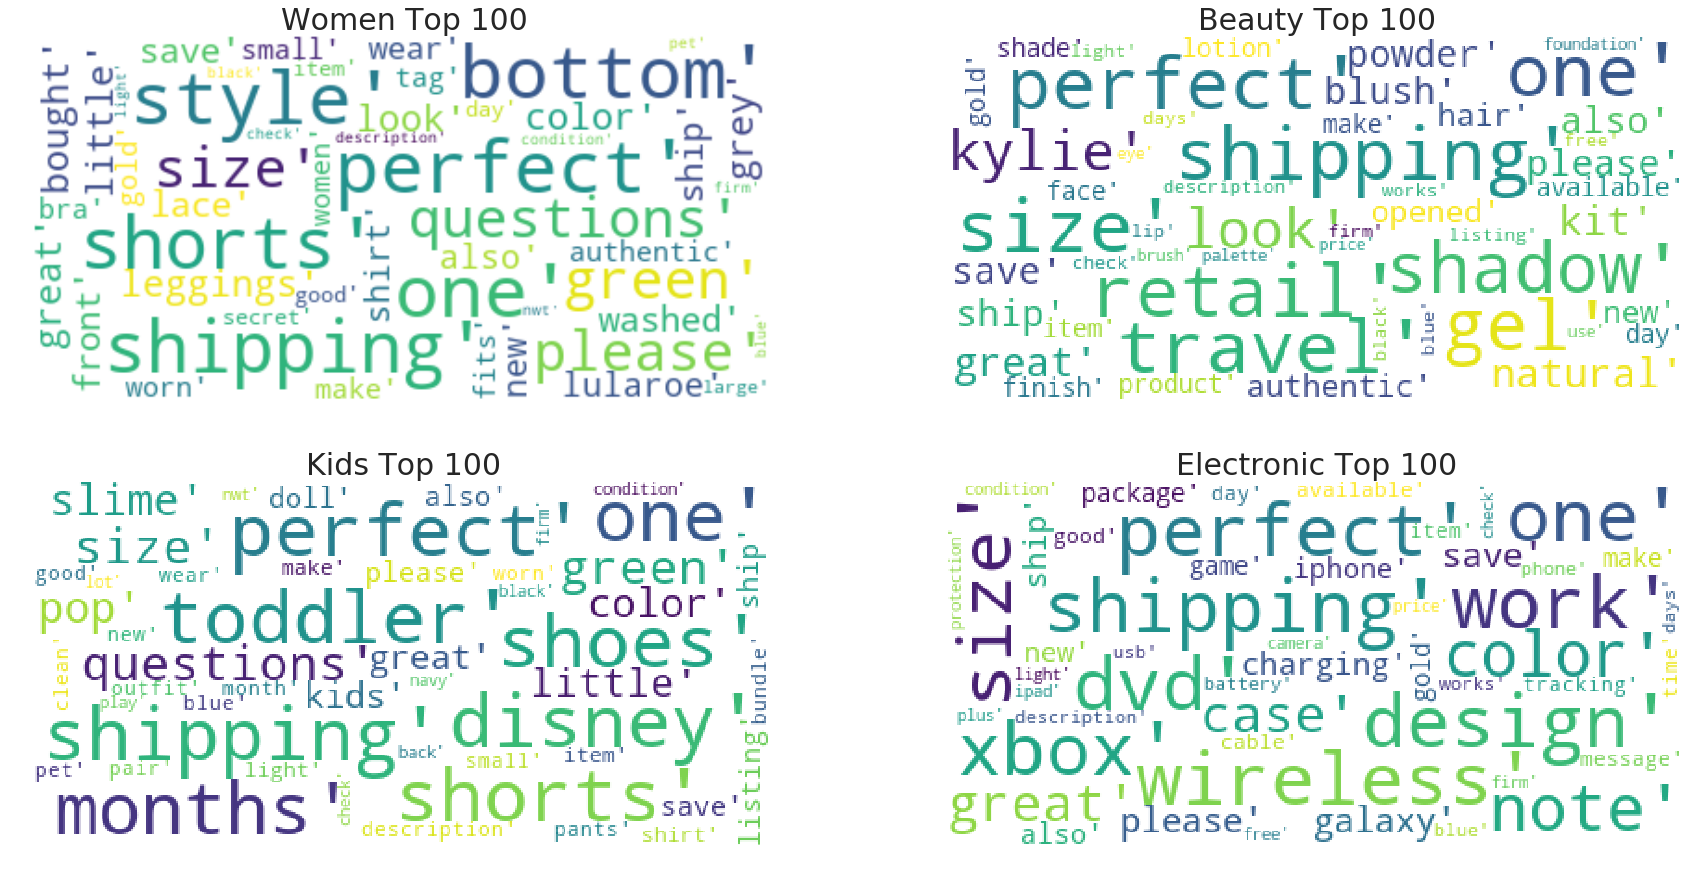

In [55]:
fig,axes = plt.subplots(2, 2, figsize=(30, 15))

ax = axes[0, 0]
ax.imshow(generate_wordcloud(women100), interpolation="bilinear")
ax.axis('off')
ax.set_title("Women Top 100", fontsize=30)

ax = axes[0, 1]
ax.imshow(generate_wordcloud(beauty100))
ax.axis('off')
ax.set_title("Beauty Top 100", fontsize=30)

ax = axes[1, 0]
ax.imshow(generate_wordcloud(kids100))
ax.axis('off')
ax.set_title("Kids Top 100", fontsize=30)

ax = axes[1, 1]
ax.imshow(generate_wordcloud(electronics100))
ax.axis('off')
ax.set_title("Electronic Top 100", fontsize=30)

## **Pre-processing:  tf-idf**

tf-idf is the acronym for **Term Frequency–inverse Document Frequency**. It quantifies the importance of a particular word in relative to the vocabulary of a collection of documents or corpus. The metric depends on two factors: 
- **Term Frequency**: the occurences of a word in a given document (i.e. bag of words)
- **Inverse Document Frequency**: the reciprocal number of times a word occurs in a corpus of documents

Think about of it this way: If the word is used extensively in all documents, its existence within a specific document will not be able to provide us much specific information about the document itself. So the second term could be seen as a penalty term that penalizes common words such as "a", "the", "and", etc. tf-idf can therefore, be seen as a weighting scheme for words relevancy in a specific document.

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10,
                             max_features=180000,
                             tokenizer=tokenize,
                             ngram_range=(1, 2))

In [57]:
%%time
all_desc = np.append(train['item_description'].values, test['item_description'].values)
vz = vectorizer.fit_transform(list(all_desc))

CPU times: user 10min 49s, sys: 2.23 s, total: 10min 52s
Wall time: 10min 51s


vz is a tfidf matrix where:
* the number of rows is the total number of descriptions
* the number of columns is the total number of unique tokens across the descriptions

In [58]:
vz

<2175890x180000 sparse matrix of type '<type 'numpy.float64'>'
	with 51926277 stored elements in Compressed Sparse Row format>

In [59]:
%%time
#  create a dictionary mapping the tokens to their tfidf values
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict(
                    dict(tfidf), orient='index')
tfidf.columns = ['tfidf']

CPU times: user 442 ms, sys: 10 ms, total: 452 ms
Wall time: 438 ms


In [60]:
print tfidf.shape
tfidf.tail()

(180000, 1)


,tfidf
negotiable make,9.684866
lined inside,9.965328
hypoallergenic guaranteed,12.158962
jawbone,11.603965
expands,10.399992


Below is the 10 tokens with the lowest tfidf score, which is unsurprisingly, very generic words that we could not use to distinguish one description from another.

In [61]:
tfidf.sort_values(by=['tfidf'], ascending=True).head(10)

,tfidf
new,2.175653
size,2.330674
brand,2.755660
condition,2.799306
brand new,2.874418
free,2.903426
shipping,3.070592
worn,3.107882
used,3.165310
never,3.276901


Below is the 10 tokens with the highest tfidf score, which includes words that are a lot specific that by looking at them, we could guess the categories that they belong to: 

In [62]:
tfidf.sort_values(by=['tfidf'], ascending=False).head(10)

,tfidf
lmt,13.195054
place step,13.195054
volts clicks,13.195054
thumb point,13.195054
colour brow,13.195054
lbs length,13.195054
wedgwood,13.195054
postnatal,13.195054
♡oval,13.195054
beats beats,13.195054


Given the high dimension of our tfidf matrix, we need to reduce their dimension using the Singular Value Decomposition (SVD) technique. And to visualize our vocabulary, we could next use t-SNE to reduce the dimension from 50 to 2. t-SNE is more suitable for dimensionality reduction to 2 or 3. 

### **t-Distributed Stochastic Neighbor Embedding (t-SNE)**

t-SNE is a technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. The goal is to take a set of points in a high-dimensional space and find a representation of those points in a lower-dimensional space, typically the 2D plane. It is based on probability distributions with random walk on neighborhood graphs to find the structure within the data. But since t-SNE complexity is significantly high, usually we'd use other high-dimension reduction techniques before applying t-SNE.

First, let's take a sample from the both training and testing item's description since t-SNE can take a very long time to execute. We can then reduce the dimension of each vector from to n_components (50) using SVD.

In [63]:
%%time
trn = train.copy()
tst = test.copy()
trn['is_train'] = 1
tst['is_train'] = 0

sample_sz = 15000

combined_df = pd.concat([trn, tst])
combined_sample = combined_df.sample(n=sample_sz)
vz_sample = vectorizer.fit_transform(list(combined_sample['item_description']))

CPU times: user 7.2 s, sys: 276 ms, total: 7.48 s
Wall time: 7.47 s


In [64]:
vz_sample

<15000x4230 sparse matrix of type '<type 'numpy.float64'>'
	with 228825 stored elements in Compressed Sparse Row format>

In [65]:
%%time
from sklearn.decomposition import TruncatedSVD

n_comp=30
svd = TruncatedSVD(n_components=n_comp, random_state=42)
svd_tfidf = svd.fit_transform(vz_sample)
print svd_tfidf.shape

(15000, 30)
CPU times: user 10.3 s, sys: 562 ms, total: 10.9 s
Wall time: 564 ms


Now we can reduce the dimension from 50 to 2 using t-SNE!

In [66]:
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, verbose=1, random_state=42, n_iter=500)
tsne_model

TSNE(angle=0.5, early_exaggeration=12.0, init='random', learning_rate=200.0,
   method='barnes_hut', metric='euclidean', min_grad_norm=1e-07,
   n_components=2, n_iter=500, n_iter_without_progress=300,
   perplexity=30.0, random_state=42, verbose=1)

In [67]:
%%time
tsne_tfidf = tsne_model.fit_transform(svd_tfidf)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 15000 samples in 0.016s...
[t-SNE] Computed neighbors for 15000 samples in 8.617s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15000
[t-SNE] Computed conditional probabilities for sample 2000 / 15000
[t-SNE] Computed conditional probabilities for sample 3000 / 15000
[t-SNE] Computed conditional probabilities for sample 4000 / 15000
[t-SNE] Computed conditional probabilities for sample 5000 / 15000
[t-SNE] Computed conditional probabilities for sample 6000 / 15000
[t-SNE] Computed conditional probabilities for sample 7000 / 15000
[t-SNE] Computed conditional probabilities for sample 8000 / 15000
[t-SNE] Computed conditional probabilities for sample 9000 / 15000
[t-SNE] Computed conditional probabilities for sample 10000 / 15000
[t-SNE] Computed conditional probabilities for sample 11000 / 15000
[t-SNE] Computed conditional probabilities for sample 12000 / 15000
[t-SNE] Computed conditional probabilities for sam

It's now possible to visualize our data points. Note that the deviation as well as the size of the clusters imply little information  in t-SNE.

In [68]:
output_notebook()
plot_tfidf = bp.figure(plot_width=700, plot_height=600,
                       title="tf-idf clustering of the item description",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

Loading BokehJS ...

In [69]:
combined_sample.reset_index(inplace=True, drop=True)

In [70]:
tfidf_df = pd.DataFrame(tsne_tfidf, columns=['x', 'y'])
tfidf_df['description'] = combined_sample['item_description']
tfidf_df['tokens'] = combined_sample['tokens']
tfidf_df['category'] = combined_sample['general_cat']

In [71]:
# import sys
# reload(sys)
# sys.setdefaultencoding("utf-8")


# plot_tfidf.scatter(x='x', y='y', source=tfidf_df, alpha=0.7)
# hover = plot_tfidf.select(dict(type=HoverTool))
# hover.tooltips={"description": "@description", "tokens": "@tokens", "category":"@category"}
# show(plot_tfidf)

## **K-Means Clustering**

K-means clustering obejctive is to minimize the average squared Euclidean distance of the document / description from their cluster centroids. 

In [72]:
from sklearn.cluster import MiniBatchKMeans

num_clusters = 30 # need to be selected wisely
kmeans_model = MiniBatchKMeans(n_clusters=num_clusters,
                               init='k-means++',
                               n_init=1,
                               init_size=1000, batch_size=1000, verbose=0, max_iter=1000)

In [73]:
kmeans = kmeans_model.fit(vz)
kmeans_clusters = kmeans.predict(vz)
kmeans_distances = kmeans.transform(vz)

In [ ]:
sorted_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

# for i in range(num_clusters):
#     print("Cluster %d:" % i)
#     aux = ''
#     for j in sorted_centroids[i, :10]:
#         aux += terms[j] + ' | '
#     print(aux)
#     print() 

********In order to plot these clusters, first we will need to reduce the dimension of the distances to 2 using tsne: 

In [ ]:
%%time
# repeat the same steps for the sample
kmeans = kmeans_model.fit(vz_sample)
kmeans_clusters = kmeans.predict(vz_sample)
kmeans_distances = kmeans.transform(vz_sample)
# reduce dimension to 2 using tsne
tsne_kmeans = tsne_model.fit_transform(kmeans_distances)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 15000 samples in 0.225s...
[t-SNE] Computed neighbors for 15000 samples in 7.798s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15000
[t-SNE] Computed conditional probabilities for sample 2000 / 15000
[t-SNE] Computed conditional probabilities for sample 3000 / 15000
[t-SNE] Computed conditional probabilities for sample 4000 / 15000
[t-SNE] Computed conditional probabilities for sample 5000 / 15000
[t-SNE] Computed conditional probabilities for sample 6000 / 15000
[t-SNE] Computed conditional probabilities for sample 7000 / 15000
[t-SNE] Computed conditional probabilities for sample 8000 / 15000
[t-SNE] Computed conditional probabilities for sample 9000 / 15000
[t-SNE] Computed conditional probabilities for sample 10000 / 15000
[t-SNE] Computed conditional probabilities for sample 11000 / 15000
[t-SNE] Computed conditional probabilities for sample 12000 / 15000
[t-SNE] Computed conditional probabilities for sam

In [ ]:
colormap = np.array(["#6d8dca", "#69de53", "#723bca", "#c3e14c", "#c84dc9", "#68af4e", "#6e6cd5",
"#e3be38", "#4e2d7c", "#5fdfa8", "#d34690", "#3f6d31", "#d44427", "#7fcdd8", "#cb4053", "#5e9981",
"#803a62", "#9b9e39", "#c88cca", "#e1c37b", "#34223b", "#bdd8a3", "#6e3326", "#cfbdce", "#d07d3c",
"#52697d", "#194196", "#d27c88", "#36422b", "#b68f79"])

In [ ]:
#combined_sample.reset_index(drop=True, inplace=True)
kmeans_df = pd.DataFrame(tsne_kmeans, columns=['x', 'y'])
kmeans_df['cluster'] = kmeans_clusters
kmeans_df['description'] = combined_sample['item_description']
kmeans_df['category'] = combined_sample['general_cat']
#kmeans_df['cluster']=kmeans_df.cluster.astype(str).astype('category')

In [ ]:
plot_kmeans = bp.figure(plot_width=700, plot_height=600,
                        title="KMeans clustering of the description",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

In [ ]:
source = ColumnDataSource(data=dict(x=kmeans_df['x'], y=kmeans_df['y'],
                                    color=colormap[kmeans_clusters],
                                    description=kmeans_df['description'],
                                    category=kmeans_df['category'],
                                    cluster=kmeans_df['cluster']))

plot_kmeans.scatter(x='x', y='y', color='color', source=source)
hover = plot_kmeans.select(dict(type=HoverTool))
hover.tooltips={"description": "@description", "category": "@category", "cluster":"@cluster" }
show(plot_kmeans)

## **Latent Dirichlet Allocation**

Latent Dirichlet Allocation (LDA) is an algorithms used to discover the topics that are present in a corpus.

>  LDA starts from a fixed number of topics. Each topic is represented as a distribution over words, and each document is then represented as a distribution over topics. Although the tokens themselves are meaningless, the probability distributions over words provided by the topics provide a sense of the different ideas contained in the documents.
> 
> Reference: https://medium.com/intuitionmachine/the-two-paths-from-natural-language-processing-to-artificial-intelligence-d5384ddbfc18

Its input is a **bag of words**, i.e. each document represented as a row, with each columns containing the count of words in the corpus. We are going to use a powerful tool called pyLDAvis that gives us an interactive visualization for LDA. 

In [ ]:
cvectorizer = CountVectorizer(min_df=4,
                              max_features=180000,
                              tokenizer=tokenize,
                              ngram_range=(1,2))

In [ ]:
%%time
cvz = cvectorizer.fit_transform(combined_sample['item_description'])

In [ ]:
lda_model = LatentDirichletAllocation(n_components=20,
                                      learning_method='online',
                                      max_iter=20,
                                      random_state=42)

In [ ]:
%%time
X_topics = lda_model.fit_transform(cvz)

In [ ]:
n_top_words = 10
topic_summaries = []

topic_word = lda_model.components_  # get the topic words
vocab = cvectorizer.get_feature_names()

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))
    print('Topic {}: {}'.format(i, ' | '.join(topic_words)))

In [ ]:
%%time
# reduce dimension to 2 using tsne
tsne_lda = tsne_model.fit_transform(X_topics)

In [ ]:
unnormalized = np.matrix(X_topics)
doc_topic = unnormalized/unnormalized.sum(axis=1)

lda_keys = []
for i, tweet in enumerate(combined_sample['item_description']):
    lda_keys += [doc_topic[i].argmax()]

lda_df = pd.DataFrame(tsne_lda, columns=['x','y'])
lda_df['description'] = combined_sample['item_description']
lda_df['category'] = combined_sample['general_cat']
lda_df['topic'] = lda_keys
lda_df['topic'] = lda_df['topic'].map(int)

In [ ]:
plot_lda = bp.figure(plot_width=700,
                     plot_height=600,
                     title="LDA topic visualization",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

In [ ]:
source = ColumnDataSource(data=dict(x=lda_df['x'], y=lda_df['y'],
                                    color=colormap[lda_keys],
                                    description=lda_df['description'],
                                    topic=lda_df['topic'],
                                    category=lda_df['category']))

plot_lda.scatter(source=source, x='x', y='y', color='color')
hover = plot_kmeans.select(dict(type=HoverTool))
hover = plot_lda.select(dict(type=HoverTool))
hover.tooltips={"description":"@description",
                "topic":"@topic", "category":"@category"}
show(plot_lda)

In [ ]:
def prepareLDAData():
    data = {
        'vocab': vocab,
        'doc_topic_dists': doc_topic,
        'doc_lengths': list(lda_df['len_docs']),
        'term_frequency':cvectorizer.vocabulary_,
        'topic_term_dists': lda_model.components_
    } 
    return data

In [ ]:
%%time
import pyLDAvis

lda_df['len_docs'] = combined_sample['tokens'].map(len)
ldadata = prepareLDAData()
pyLDAvis.enable_notebook()
prepared_data = pyLDAvis.prepare(**ldadata)